In [65]:
# Load sentence retrieval result
import json 
with open("/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-gpt-queries-retrieval.jsonl") as f:
    result = [json.loads(i) for i in f.readlines()]

In [66]:
# Load csv file for recall, precision, and f1
import pandas as pd
path = "/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-n-query-mt-2.csv"
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index("corpus-id")

In [67]:
# Load dataset queries and corpus
def load_dict(pth):
    with open(pth) as f:
        lines = [json.loads(i) for i in f.readlines()]
    if "text" in lines[0]:
        return {str(i["_id"]): i["text"] for i in lines}
    elif "queries" in lines[0]:
        return {str(i["_id"]): i["queries"] for i in lines}

queries = load_dict("/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/queries.jsonl")
docs = load_dict("/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/corpus.jsonl")
llm_queries = load_dict("/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/queries-gpt4o.jsonl")
qrels = pd.read_csv("/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/qrels/test.tsv", sep="\t")

In [68]:
# Get grad norm dict

pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_gradnorms(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            l = l.replace('\'', '"')
            item = json.loads(l)
            gradnorms.append(float(item["grad_norm"]))
            '''
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
            '''
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    ids_selected = []
    #func = lambda x: sum(x[:4]) / len(x[:4])
    def func(x):
        x = [i for i in x if i > 1]
        return sum(x[:4]) / len(x[:4])
    for i in range(0, len(ids), 4):
        gradnorms_selected.append(func(gradnorms[i:i+4]))
        ids_selected.append(ids[i])
    gradnorm_dict = {cid: gradnorm for cid, gradnorm in zip(ids_selected, gradnorms_selected)}
            
    return gradnorm_dict

gradnorm_dict = get_gradnorms(pth + "ood_all")

In [69]:
# Load result
cids = []
scores = []
recalls = []
precisions = []
gradnorms = []
f1s = []
for i in result:
    cid = i["_id"]
    if cid not in gradnorm_dict:
        print(cid)
        continue
    succ = sum(map(lambda x: cid in x, i["retrieval"][:100]))
    count = len(i["retrieval"])
    if count < 3:
        continue
    score = round(succ / count * 100, 2)
    cids.append(cid)
    scores.append(score)
    recalls.append(df.loc[cid]["recall"])
    precisions.append(df.loc[cid]["precision"])
    f1s.append(df.loc[cid]["f1"])
    gradnorms.append(gradnorm_dict[cid])
    

5czqzmvj


In [70]:
import matplotlib.pyplot as plt 
#fig = plt.figure()
recalls_ref = sorted([round(i, 2) for i in set(recalls)])
scores_ref = sorted([round(i, 2) for i in set(scores)])
recalls_ = [round(i, 2) for i in recalls]
scores_ = [round(i, 2) for i in scores]
scores_recalls = sorted([(s, r, cid) for s, r, cid in zip(scores_, recalls_, cids)], key= lambda x: x[0])
#print(scores_)

document_ids_dict = {str(s): {str(r): [] for r in recalls_ref} for s in scores_ref}
entire_results = []
for s in scores_ref:
    results = [0 for _ in recalls_ref]
    for si, ri, cid in scores_recalls:
        if si != s:
            continue
        results[recalls_ref.index(ri)] += 1
        document_ids_dict[str(s)][str(ri)].append(cid)
    entire_results.append(results)
    #print(s, ":", results)
retrieval_res = {i["_id"]: i["retrieval"] for i in result}

df = pd.DataFrame(entire_results, columns=recalls_ref)
df["llm-q-recall"] = scores_ref
df = df.set_index("llm-q-recall")
df

,0.0,0.08,0.1,0.12,0.14,0.17,0.2,0.25,0.33,0.4,0.5,0.67,1.0
llm-q-recall,,,,,,,,,,,,,
0.00,1,0,0,0,0,0,1,1,2,0,2,0,0
10.00,5,1,0,1,0,0,0,4,6,0,13,1,0
12.50,0,0,0,0,0,0,0,1,0,0,1,0,0
18.75,2,0,0,0,0,1,0,0,0,0,3,0,0
20.00,7,0,0,0,1,0,4,1,5,0,27,1,3
30.00,8,0,0,1,0,3,1,5,18,2,33,2,9
31.25,0,0,0,0,0,0,0,0,0,0,1,0,0
37.50,0,0,0,0,0,0,0,2,2,0,0,0,1
40.00,8,0,0,1,0,1,2,12,28,0,65,3,5


In [71]:
s = "100.0"
r = "1.0"
document_ids_dict[s][r]

['959w9sln',
 'ej93duxi',
 'oyxxji7r',
 'nfjkcmxu',
 '0ec1cu8q',
 '3tna1y5o',
 'iaatjew2']

In [72]:
s = "100.0"
r = "0.0"
document_ids_dict[s][r]

['ojjzetc8', 'bfq66x1c', 'u21glvb4', 'wrrybwda', '48ay8yl3']

In [91]:
cid = "13z63d4y"
gradnorm_dict[cid]

53.407155990600586

In [94]:
recall = document_ids_dict["50.0"]
for r, llm_recall in recall.items():
    print(r)
    for _id in llm_recall:
        print(_id, round(gradnorm_dict[_id], 2))

0.0
sqrn6kjy 41.6
s33brsk6 28.34
vznb3puk 48.22
b8ce35l4 41.7
nrtrhq1f 46.72
kiq6xb6k 34.68
8wb6u7dc 19.3
68spkk3y 26.31
j59tm40d 22.87
ncarr4jq 45.45
1intktsf 42.76
9fnpfncr 38.37
e995ev2w 46.15
9od553a6 34.27
dqour5jr 47.63
q85u5v8s 41.63
0kxo3a4q 42.31
dubxmtfv 54.58
jvc9u0o0 56.59
0.08
0.1
bu17n7zf 48.59
0.12
b0aaozmn 37.65
4cx6fe5v 25.92
0.14
0376d6vf 26.37
0.17
dmrtsxik 38.33
0.2
ycrrsr5c 30.63
ooboeurk 33.17
0.25
oihyz5v7 21.94
a47onmje 31.53
5o9bbspc 31.71
xpbcoipf 13.36
o3nfoqgs 31.29
1vhxcbx7 40.82
40xsypzt 27.52
2705en59 30.77
0.33
k9yus2sv 27.52
hiw576og 45.1
7jwhypgs 34.99
lv5xjfk4 48.58
jbc74lcu 29.51
q2b4ig1h 7.95
9skvbk8m 38.63
ioo17gc3 10.3
9rg9xe57 25.66
xbw72k4m 26.7
3ysa4twk 11.97
mgp38mdz 11.0
wxpfg25n 21.18
ja9qu3p8 14.03
zgrr2hdi 23.44
2ik1rbto 30.01
0gozdv43 34.33
q4m4q6p0 31.46
5yvjbr5q 23.91
gwm36n75 24.11
kxnm8l2z 26.98
0s7oq0uv 46.15
c5fygzvz 14.67
13z63d4y 53.41
4y5279c5 57.13
13ir7swr 44.5
k2juhyex 47.63
33nyo8r5 47.94
xb4ld4tr 17.06
6dq6gm27 31.93
5mh3ds6

In [ ]:
0.0
sqrn6kjy 41.6
s33brsk6 28.34
vznb3puk 48.22
b8ce35l4 41.7
nrtrhq1f 46.72
kiq6xb6k 34.68
8wb6u7dc 19.3
68spkk3y 26.31
j59tm40d 22.87
ncarr4jq 45.45
1intktsf 42.76
9fnpfncr 38.37
e995ev2w 46.15
9od553a6 34.27
dqour5jr 47.63
q85u5v8s 41.63
0kxo3a4q 42.31
dubxmtfv 54.58
jvc9u0o0 56.59
0.08
0.1
bu17n7zf 48.59
0.12
b0aaozmn 37.65
4cx6fe5v 25.92
0.14
0376d6vf 26.37
0.17
dmrtsxik 38.33
0.2
ycrrsr5c 30.63
ooboeurk 33.17
0.25
oihyz5v7 21.94
a47onmje 31.53
5o9bbspc 31.71
xpbcoipf 13.36
o3nfoqgs 31.29
1vhxcbx7 40.82
40xsypzt 27.52
2705en59 30.77
0.33
k9yus2sv 27.52
hiw576og 45.1
7jwhypgs 34.99
lv5xjfk4 48.58
jbc74lcu 29.51
q2b4ig1h 7.95
9skvbk8m 38.63
ioo17gc3 10.3
9rg9xe57 25.66
xbw72k4m 26.7
3ysa4twk 11.97
mgp38mdz 11.0
wxpfg25n 21.18
ja9qu3p8 14.03
zgrr2hdi 23.44
2ik1rbto 30.01
0gozdv43 34.33
q4m4q6p0 31.46
5yvjbr5q 23.91
gwm36n75 24.11
kxnm8l2z 26.98
0s7oq0uv 46.15
c5fygzvz 14.67
13z63d4y 53.41
4y5279c5 57.13
13ir7swr 44.5
k2juhyex 47.63
33nyo8r5 47.94
xb4ld4tr 17.06
6dq6gm27 31.93
5mh3ds6y 37.31
86byq11c 29.95
5rfxis6f 28.97
uc37poce 27.89
y6ssshea 32.98
m63b9ekk 34.53
yb5kf0u2 42.36
0.4
0.5
k9lcpjyo 50.07
jwxt4ygt 46.41
9xueqdri 41.74
ww1rgcds 37.0
wic7n6ia 10.97
7qd8z5e7 16.41
vzyrcmu4 13.57
1dr4r3n4 40.8
ij4ibrrx 41.11
77rcr30x 41.34
01mo6yo9 24.26
lsb1s8y7 16.55
0jl6qu0i 42.61
d0y3pr9a 16.74
uxeaaski 31.42
8b5e0s5x 13.86
8cg5yj20 26.54
3nipr212 16.25
j8x384vp 7.81
54obt430 27.0
c0i11t0a 28.91
jmhexmet 14.27
4uslmbmw 17.09
2yblpbwm 26.34
h7vqmlq9 46.94
k9xhphpl 11.6
kngf6qpe 38.86
opltcnyi 23.08
r1oqwdkz 24.36
wncw27t7 5.25
za4x9igf 29.12
3jcedmrt 46.24
2h3oslv2 19.33
b1roq671 28.83
komx6t5h 17.1
lnjlyaex 23.36
5zb96j4a 27.7
japmze1b 26.89
pd70i3d8 22.96
kbp47abd 31.7
g9qlo3xh 27.73
0zxj41xe 35.35
n5b9dcvo 15.59
zuchss0s 28.42
9qahwku6 31.45
z15l4pcq 28.24
dnv2xl0h 17.89
6rnko6tl 16.08
jozd45ch 35.14
7ftg6bfx 24.03
b4mdiont 32.02
qxsr3uii 16.22
4el6qq3n 31.44
kjc3j7yz 17.76
xrvynfr6 5.03
f5s0ntps 25.3
v666xzjj 21.96
mp3196kj 26.0
edbtz6up 47.04
yaov2osz 5.3
c5co9cfq 33.11
1hfnv35j 23.53
uzfpv5rd 8.65
8mei3fqy 21.21
ktzx5lz6 14.83
67gsn4sy 9.77
27oqmd89 22.64
m16by8h6 9.97
ipl6189w 41.92
7hnh85wy 37.75
yx9oa2ra 48.68
9b6cepf4 20.19
844229sb 5.66
0l78gpg3 17.39
6tod4abn 16.61
zv4jnvy1 22.29
gc8770l9 8.81
l5n0r5g9 49.04
yo29hay0 36.99
pukl3vhs 37.89
0.67
vyeescn8 29.96
h7ftu3ax 31.93
n4dgqo73 24.38
b61alj5x 27.09
zm8hpuer 53.49
1.0
378cfb23 61.45
d44coxr1 42.93
cb5ebiiv 27.25
51g3vhcx 21.77
eke4f5fn 35.34
hsbjbwpa 45.9
1aqf98e0 9.2
iylmvmv3 6.45
hl225efn 22.45
04s7w017 20.86
06gbt9t0 55.0

In [98]:
cid = "ioo17gc3"
gradnorm_dict[cid]

10.295510292053223

In [99]:
print(cid)
print(docs[cid])
print()
qids = qrels[qrels["corpus-id"] == cid]["query-id"].values
count = 0
for i in qids:
    count += 1
    print(f"Q{count}. {queries[str(i)]}")
print()
count = 0
for i in llm_queries[cid]:
    count += 1
    print(f"Q{count}. {i}")
print()

ioo17gc3
Abstract The advent of novel human coronavirus (SARS-CoV-2) and its potential transmission via fecal-oral and aerosols-borne routes are upcoming challenges to understand the fate of the virus in the environment. In this short communication, we specifically looked at the possibilities of these transmission routes based on the available literature directly related to the SARS-CoV-2 as well as on the closer phylogenetic relatives such as SARS-CoV-1. The available data suggest that, in addition to human-to-human contact, the virus may spread via fecal-oral and aerosols-borne routes. Existing knowledge states that coronaviruses have low stability in the environment due to the natural action of oxidants that disrupt the viral envelope. Previous recommended dosage of chlorination has been found to be not sufficient to inactivate SARS-CoV-2 in places where viral load is high such as hospitals and airports. Although there is no current evidence showing that coronaviruses can be transmi

In [102]:
list(map(lambda x: cid in x, retrieval_res[cid]))

[False, False, True, False, False, True, False, True, True, True]

In [101]:
gradnorm_dict["8wb6u7dc"]

19.297863006591797

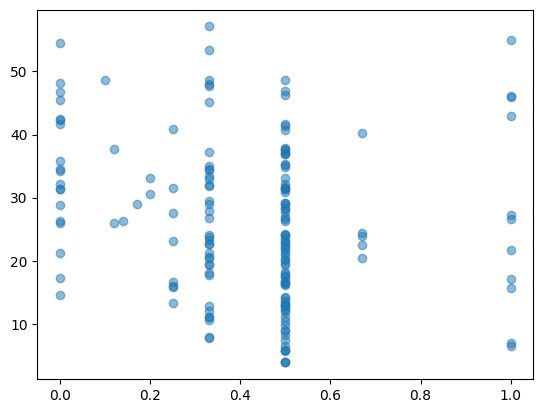

In [17]:
xs, ys = [], []
for k, v in document_ids_dict["50.0"].items():
    for cid in v:
        gn = gradnorms[cids.index(cid)]
        xs.append(float(k))
        ys.append(gn)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(xs, ys, alpha=0.5)

### Plot recall - gradnorm

/tmp/ipykernel_1390922/3313119120.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(1068, 1068)

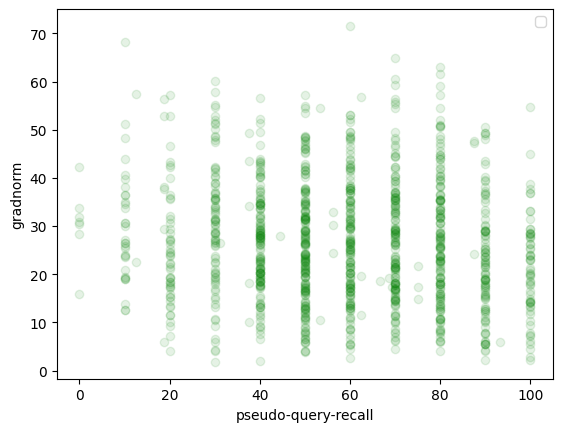

In [59]:
# Compare sentence recall to gradnorm

import matplotlib.pyplot as plt 
plt.figure()
plt.xlabel("pseudo-query-recall")
plt.ylabel("gradnorm")

plt.scatter(scores, gradnorms, marker="o", color="green", alpha=0.1)
plt.legend()

len(scores), len(gradnorms)

/tmp/ipykernel_1602106/352914346.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


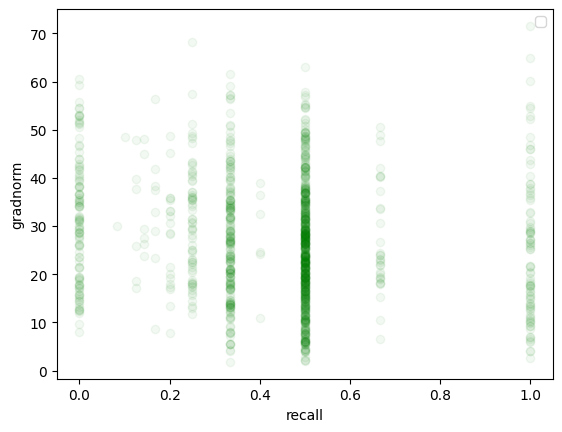

In [95]:
# Compare recall to gradnorm

import matplotlib.pyplot as plt 
plt.figure()
plt.xlabel("recall")
plt.ylabel("gradnorm")

plt.scatter(recalls, gradnorms, marker="o", color="green", alpha=0.05)
plt.legend()
 

### Load grad norm and plot mean 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2500 2500 2500


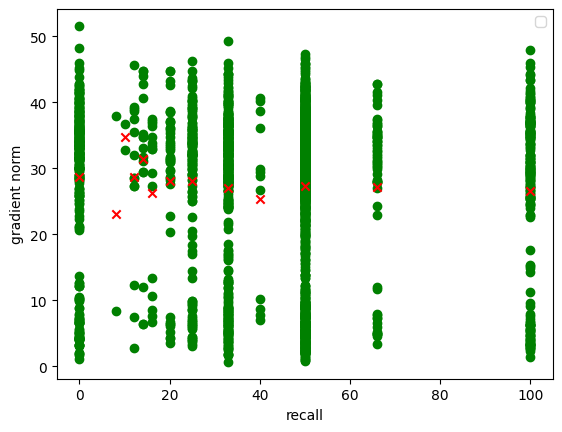

In [16]:
pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_recall_and_score_list(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
        except:
            continue
    recalls = []
    for l in lines:
        try: 
            sid = l.index("recall: ") + len("recall: ") 
            eid = sid + 5
            recalls.append(int(float(l[sid:eid].strip()) * 100))
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    recalls_selected = []
    ids_selected = []
    func = min #lambda x: sum(x) / len(x)
    for i in range(0, len(ids), 4):
        gradnorms_selected.append(func(gradnorms[i:i+4]))
        recalls_selected.append(func(recalls[i:i+4]))
        ids_selected.append(ids[i])
            
    return recalls_selected, gradnorms_selected, ids_selected



ood_all = pth + "ood_all_update"
recalls, gradnorms, ids = get_recall_and_score_list(ood_all)
print(len(recalls), len(gradnorms), len(ids))

import matplotlib.pyplot as plt 
plt.figure()
plt.scatter(recalls, gradnorms, color="green")
plt.xlabel("recall")
plt.ylabel("gradient norm")
#plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
#plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")

means = {k: [] for k in set(recalls)}
for r, g in zip(recalls, gradnorms):
    means[r].append(g)
means = {k: sum(v) / len(v) for k, v in means.items()}
means = sorted(list(means.items()), key= lambda x: int(x[0]))
xs = [i[0] for i in means]
ys = [i[1] for i in means]
plt.scatter(xs, ys, marker="x", color="red")
plt.legend()
 